In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

# Multi Layer Perceptron with Tensorflow

MLP on MNIST. 

Here we flatten mnist and train an MLP classifier. Test accuracy is about 92%. This is mostly for practice. For images, you'll probably want to use something that takes advantage of the structure in the data e.g. a CNN. 

## Download Data

In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()

# rescale x to be in [0,1]
x_train, x_test = x_train / 255.0, x_test / 255.0

# flatten x
x_train = x_train.reshape([60000, -1])
x_test = x_test.reshape([10000, -1])

# categorical encoding for y
n_classes = 10

y_train_cat = np.zeros([len(y_train), n_classes])
y_train_cat[range(len(y_train)),y_train]= 1


y_test_cat = np.zeros([len(y_test), n_classes])
y_test_cat[range(len(y_test)),y_test]= 1


print('x train: ', x_train.shape)
print('y train: ', y_train_cat.shape)


print('x test: ', x_test.shape)
print('y test: ', y_test_cat.shape)

x train:  (60000, 784)
y train:  (60000, 10)
x test:  (10000, 784)
y test:  (10000, 10)


# MLP in TF

In [3]:
# util 

def accuracy(y, y_pred):
    
    return sum(y==y_pred)/len(y)

In [4]:
class MLP:
    
    def __init__(self, layer_dims, input_dim, n_classes):
        
        self.sess = tf.Session()
        
        self.layer_dims = layer_dims
        
        self.x = tf.placeholder(name = 'input',
                                shape = (None, input_dim),
                                dtype = tf.float32)
        
        self.ground_truth = tf.placeholder(name = 'ground_truth',
                                           shape = (None, n_classes),
                                           dtype = tf.float32)   
        
        self.initialize = False
        
        self.build()
        
    def build(self):
        
        self.build_forward()
        self.build_train()
        self.build_aux()
        
    def build_forward(self):
        '''Build forward pass'''
        
        for i, dim in enumerate(self.layer_dims):

            if i == 0:
                y = tf.layers.Dense(units = dim, activation=tf.nn.relu)(self.x)
            else:
                y = y = tf.layers.Dense(units = dim, activation=tf.nn.relu)(y)

        # logits here since loss performs softmax for numerical reasons
        self.logits = tf.layers.Dense(n_classes, activation=None)(y)

        
    def build_train(self):
        
        # cross-entropy
        self.loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits_v2(
                labels=self.ground_truth, logits=self.logits))
        
        # minimize loss with Adam
        self.train_step = tf.train.AdamOptimizer().minimize(self.loss)
        
    def build_aux(self):
        
        # predicted probabilities
        _probs = tf.nn.softmax(self.logits)
 
        # predicted class (arg max)
        self.pred = tf.argmax(_probs, axis = 1)
        
    def train(self, X_train, y_train,num_epoch, batch_size, initialize = False, verbose = False):
        
        if not self.initialize or initialize:
            print('Initializing Model')
            init_var = tf.global_variables_initializer()
            self.sess.run(init_var)
            self.initialize = True

        N = len(X_train)

        idx = np.arange(N)
        n = (N%batch_size)*batch_size
        loss_val = []

        for epoch in range(num_epoch):

            np.random.shuffle(idx)

            idx = idx[:n].reshape([-1, batch_size])

            for batch_idx in idx:

                x_batch = X_train[batch_idx]
                y_batch = y_train_cat[batch_idx]

                feed_dict = {self.x: x_batch, self.ground_truth: y_batch}
                self.sess.run(self.train_step, feed_dict=feed_dict)

                _l = self.sess.run(self.loss, feed_dict=feed_dict)
                loss_val.append(_l)
                
            if verbose:
                _y_pred = self.predict(X_train[:500])
                _y_train = y_train[:500].argmax(1)
                print('Epoch {}   Train Acuracy {}'.format(epoch+1, accuracy(_y_train, _y_pred)))
                
        return loss_val
    
    def predict(self,X, batch = 128):
        
        y_pred = []
        
        i = 0
        while i+batch <= len(X):
            xx = X[i:i+batch]
            _y  = self.sess.run(self.pred, feed_dict = {self.x: xx})
            y_pred.extend(_y)
            
            i+=batch

        xx = X[i:]
        _y  = self.sess.run(self.pred, feed_dict = {self.x: xx})
        y_pred.extend(_y)
            
        return np.array(y_pred)
    

In [5]:
tf.reset_default_graph()

In [6]:
m = MLP(layer_dims=[512,512], input_dim=784, n_classes=10)
loss_val = m.train(x_train, y_train_cat, num_epoch=20, batch_size=64, verbose = True)

Initializing Model
Epoch 1   Train Acuracy 0.872
Epoch 2   Train Acuracy 0.892
Epoch 3   Train Acuracy 0.916
Epoch 4   Train Acuracy 0.916
Epoch 5   Train Acuracy 0.914
Epoch 6   Train Acuracy 0.922
Epoch 7   Train Acuracy 0.922
Epoch 8   Train Acuracy 0.928
Epoch 9   Train Acuracy 0.924
Epoch 10   Train Acuracy 0.928
Epoch 11   Train Acuracy 0.93
Epoch 12   Train Acuracy 0.932
Epoch 13   Train Acuracy 0.93
Epoch 14   Train Acuracy 0.932
Epoch 15   Train Acuracy 0.932
Epoch 16   Train Acuracy 0.93
Epoch 17   Train Acuracy 0.934
Epoch 18   Train Acuracy 0.93
Epoch 19   Train Acuracy 0.932
Epoch 20   Train Acuracy 0.932


Text(0.5,0,'steps')

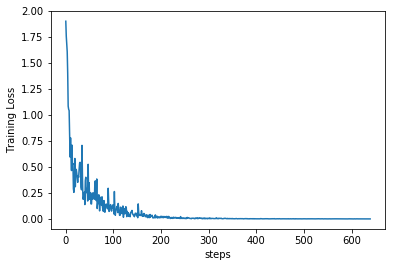

In [7]:
plt.plot(loss_val)
plt.ylabel('Training Loss')
plt.xlabel('steps')

In [8]:
y_test_pred = m.predict(x_test)
acc = accuracy(y_test, y_test_pred)

print('Test Accuracy: {}'.format(acc))

Test Accuracy: 0.9314
